# Задание 5.

Загрузите [данные по изменению температуры поверхности земли](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data). Для этого может понадобится зарегистрироваться на [Kaggle](https://kaggle.com). Затем нужно будет работать с данными, которые содержатся в файле **GlobalLandTemperaturesByMajorCity.csv**

**NB** Все подсчеты необходимо делать с помощью `PySpark`, без применения `pandas api`. Можно использоать `SQL`.

In [ ]:
import zipfile

import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

%matplotlib inline

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("PySpark") \
    .getOrCreate()

with zipfile.ZipFile("archive.zip") as z:
    with z.open("GlobalLandTemperaturesByMajorCity.csv") as f:
        pandas_df = pd.read_csv(f)
        df = spark.createDataFrame(pandas_df)

df.show(10)

# Задание 3.1 (1 балл)

В последующих заданиях будут учитываться данные начиная с 01.01.1950. Для этого создайте новый `DataFrame`, в котором удалены все строки до 01.01.1950. Используйте созданный DataFrame в последующих заданиях.  

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col

spark = SparkSession.builder.appName("first").getOrCreate()

df = spark.read.csv("./GlobalLandTemperaturesByMajorCity.csv", header=True, inferSchema=True)


df = df.withColumn("dt", to_date(col("dt"), "dd.MM.yyyy"))
df = df.filter(col("dt") >= "1950-01-01")

df.write.csv("./new.csv", header=True)
df.show(10)



+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1950-01-01|26.773000000000003|                        0.239|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-02-01|27.526999999999997|                        0.348|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-03-01|            28.344|                        0.431|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-04-01|             27.83|                        0.467|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-05-01|            26.896|                        0.248|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-06-01|            25.454|                        0.209|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-07-01|            24.878|                        0.403|Abidjan|Côte

# Задание 3.2 (2 балла)

Постройте график среднегодовых температур в городе Торонто.

+----+------------------+
|Year|   Avg Temperature|
+----+------------------+
|1950| 5.639583333333334|
|1951| 6.259083333333334|
|1952| 7.013416666666667|
|1953|7.5062500000000005|
|1954| 6.243083333333332|
+----+------------------+
only showing top 5 rows



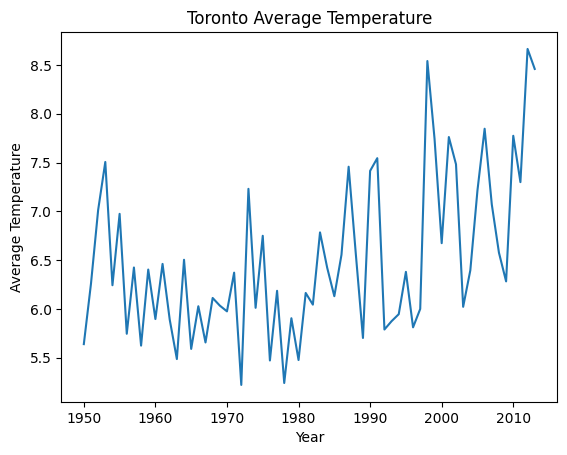

In [11]:
toronto_df = df.filter(df.City == "Toronto")

from pyspark.sql.functions import year, avg

toronto_avg_temp = toronto_df.groupBy(year("dt").alias("Year")).agg(avg("AverageTemperature").alias("Avg Temperature"))
toronto_avg_temp = toronto_avg_temp.orderBy("Year")
toronto_avg_temp.show(5)

import matplotlib.pyplot as plt

x = toronto_avg_temp.select("Year").rdd.flatMap(lambda x: x).collect()
y = toronto_avg_temp.select("Avg Temperature").rdd.flatMap(lambda x: x).collect()

plt.plot(x, y)
plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.title("Toronto Average Temperature")
plt.show()

# Задание 3.3 (2 балла)

Найдите город, для которого выборочная дисперсия температур на приведенных данных максимальна. 

In [23]:
from pyspark.sql.functions import var_pop

df2 = df
variances = df2.groupBy("City").agg(var_pop("AverageTemperature").alias("variance"))
max_variance_city = variances.orderBy("variance", ascending=False).first()["City"]
variances.orderBy("variance", ascending=False).show(5)
print("Город с максимальной выборочной дисперсией температур:", max_variance_city)

+---------+------------------+
|     City|          variance|
+---------+------------------+
|   Harbin|218.61209943879504|
|Changchun|194.34576350206132|
| Shenyang|147.88712897884355|
| Montreal|122.04443511694808|
|   Peking|120.42776059592659|
+---------+------------------+
only showing top 5 rows

Город с максимальной выборочной дисперсией температур: Harbin


# Задание 3.4 (4 балла)

На одной оси постройте графики, отображающие:
1. Зависимость выборочной дисперсии температур от широты города (Latitude).
2. Зависимость средней температуры в январе 1975 года от широты города (Latitude).
3. Зависимость средней температуры в июле 1975 года от широты города (Latitude).

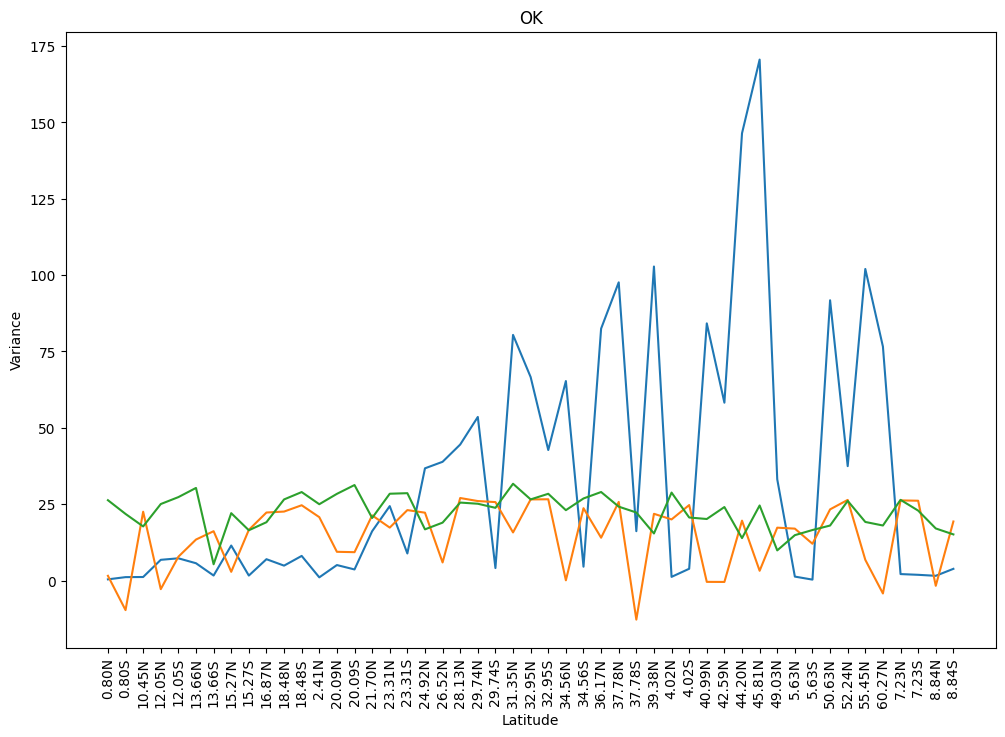

In [59]:
df3 = df

first = df3.groupBy("Latitude").agg(var_pop("AverageTemperature").alias("variance"))
first = first.orderBy("Latitude")
x = first.select("Latitude").rdd.flatMap(lambda x: x).collect()
y = first.select("variance").rdd.flatMap(lambda x: x).collect()

second = df3.filter((col("dt") == "1975-01-01"))
second = second.groupBy("Latitude").agg(avg("AverageTemperature").alias("AverageTemperature"))
y2 = second.select("AverageTemperature").rdd.flatMap(lambda x: x).collect()

third = df3.filter((col("dt") == "1975-07-01"))
third = third.groupBy("Latitude").agg(avg("AverageTemperature").alias("AverageTemperature"))
y3 = third.select("AverageTemperature").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12,8))
plt.plot(x, y, x, y2, x, y3)
plt.xticks(x, rotation= 90)
plt.xlabel("Latitude")
plt.ylabel("Variance")
plt.title("OK")
plt.show()


# Задание 3.5 (6 баллов)

Посчитайте данные по среднегодовой температуре в Санкт-Петербурге. Определите года, в которых средняя температура была выше, чем в предыдущем  и последующем году. Постройте график среднегодовой температуры и обозначьте на нём найденные года (произвольным образом). 

Постройте модель линейной регрессии (можно использовать [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)): $\mathbb{год} \rightarrow \mathbb{средняя\_температура}$. Отобразите прямую на предыдущем графике. 

# Задание 3.6 (4 балла)

Найдите города, для которых: 
1. Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.
2. Самая большая средняя разница между средней температурой января и средней температурой июля.
3. Наибольшее среднее количество месяцев с отрицательной температурой в году.

# Задание 3.7 (3 балла)

Отобразите города на карте, например с помощью [geopandas/folium](https://geopandas.org/en/stable/gallery/plotting_with_folium.html) или [plotly](https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html). Причем цвет метки должен соответствовать средней температуре в январе за последние 10 лет. 


**\***(+3 балла). Вычислите прямую с "трендом" по изменению средней температуры за год в каждом городе в период 1950-2013 (можно с помощью линейной регрессии, как в задании **3.5**). Отобразите города цветом, который зависит от угла наклона этой прямой. 


**\***(+1 балл) В дополнение к предыдущему пункту, используйте библиотеку [pwlf](https://pypi.org/project/pwlf/) с фиксированным числом сегментов и визуализируйте угол наклона последнего сегмента. 

# *Задание 3.8 (8 баллов)

Цель - создать проект, который как минимум включает:
1. Использование юнит-тестов ([pytest](https://pytest.org)).
2. Применение средств форматирования и проверки исходного кода (например: [isort](https://pycqa.github.io/isort/), [black](https://black.readthedocs.io/en/stable/), [flake8](https://flake8.pycqa.org/en/latest/), [mypy](https://mypy.readthedocs.io/en/stable/)).
3. Спецификацию проекта в [pyproject.toml](https://pip.pypa.io/en/stable/reference/build-system/pyproject-toml/).
4. Использование утилит для работы с командной строкой ([argparse](https://docs.python.org/3/library/argparse.html), [click](https://click.palletsprojects.com/en/8.1.x/) и т.п.)
5. Сборку проекта в Wheel-файл.

Проект должен быть загружен в репозиторий. Функционал - произвольный, но должны использоваться данные из этого домашнего задания. Сам файл передается в качестве первого аргумента командной строки.  Например:

> python3 -m homeproject.app GlobalLandTemperaturesByMajorCity.csv 1980

Выдает самый жаркий месяц и город по наблюдениям за 1980 год.

*Ссылка на проект*